In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import librosa.display
import IPython.display as ipd
import warnings
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [82]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [83]:
print(os.listdir("Data/genres_original"))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [84]:
# Understanding the Audio Files

y, sr = librosa.load("Data/genres_original/blues/blues.00000.wav")

print("Sound Array :", y)
print("Sample Rate (KHz)", sr)

Sound Array : [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Sample Rate (KHz) 22050


In [85]:
# Trimming the Silence sequences sandwiching the audio file

y, _ = librosa.effects.trim(y)
print(y)

# Observe no preceeding or succeding silence

[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


Text(0.5, 1.0, 'Waveform in Blues 0')

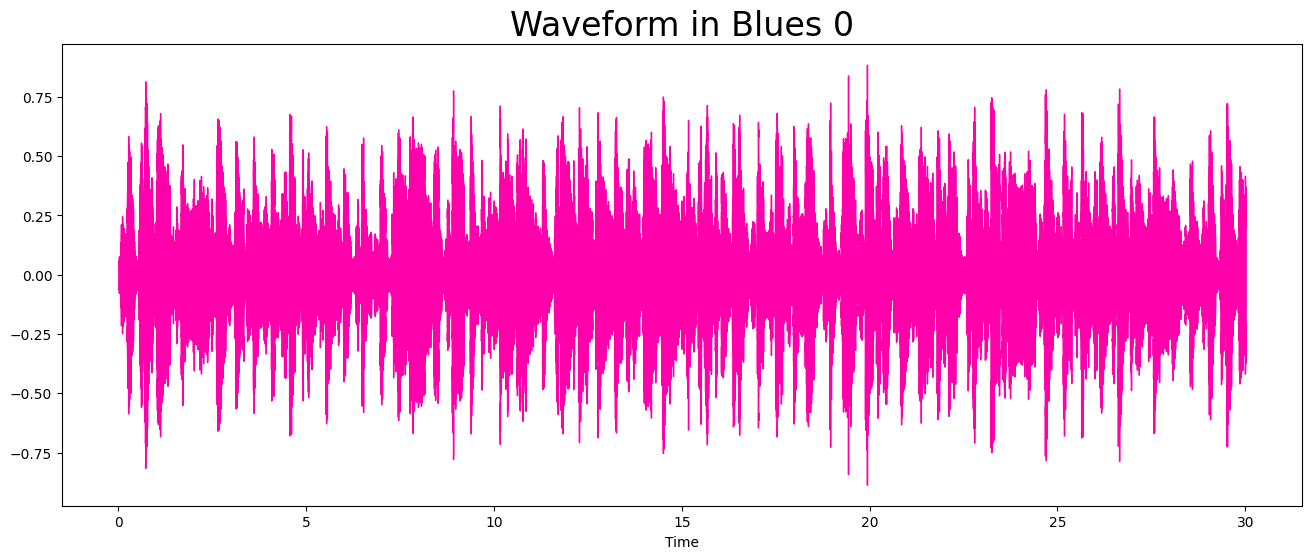

In [86]:
# 2D Representation using Waveform

plt.figure(figsize = (16,6))
librosa.display.waveshow(y = y, sr = sr, color = "#FF00AB");
plt.title("Waveform in Blues 0", fontsize = 24)

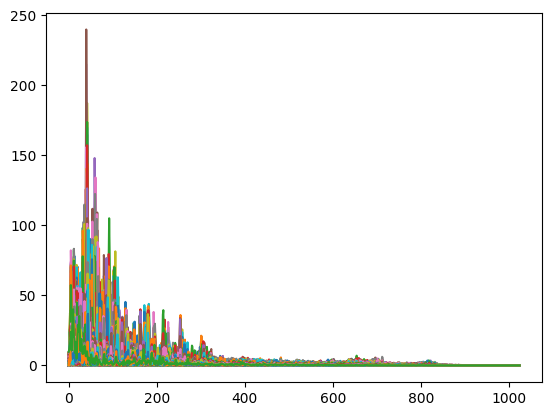

In [87]:
# Decomposing the waveform based on the frequencies using FFT

n_fft = 2048
hop_length = 512

D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))

plt.plot(D)
plt.show()

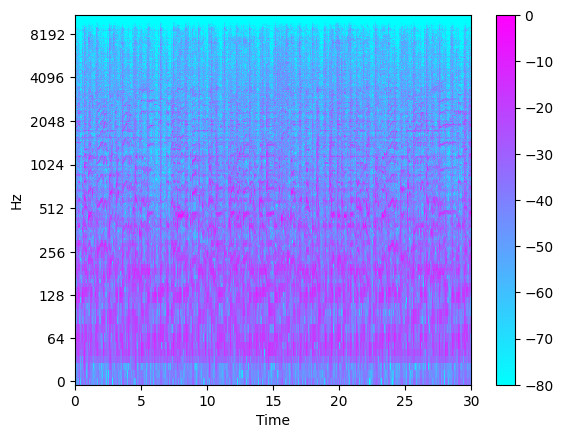

In [88]:
# Creating Log Frequency Spectogram from the FFT Signal
# This also scales to the decibel system, as that is also log based.

Deci = librosa.amplitude_to_db(D, ref = np.max)
librosa.display.specshow(Deci, sr = sr, hop_length=hop_length, x_axis='time',y_axis='log',cmap = 'cool')

plt.colorbar()

Text(0.5, 1.0, 'Mel Spectrogram')

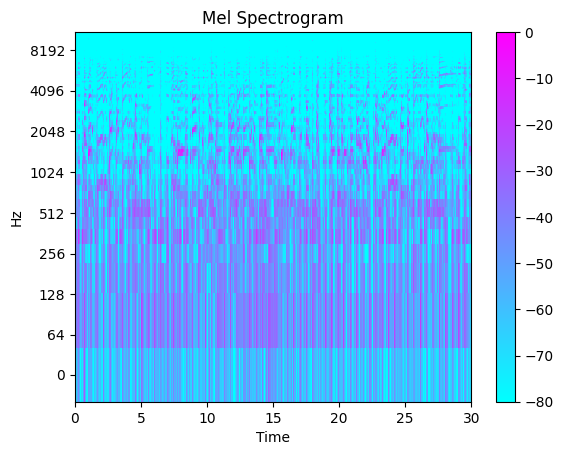

In [89]:
# Mel Spectrogram form the data

Mel_S = librosa.feature.melspectrogram(y =y, sr= sr)
Deci_S = librosa.amplitude_to_db(Mel_S, ref = np.max)
librosa.display.specshow(Deci_S, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',cmap = 'cool')
plt.colorbar()
plt.title("Mel Spectrogram", fontsize = 12)

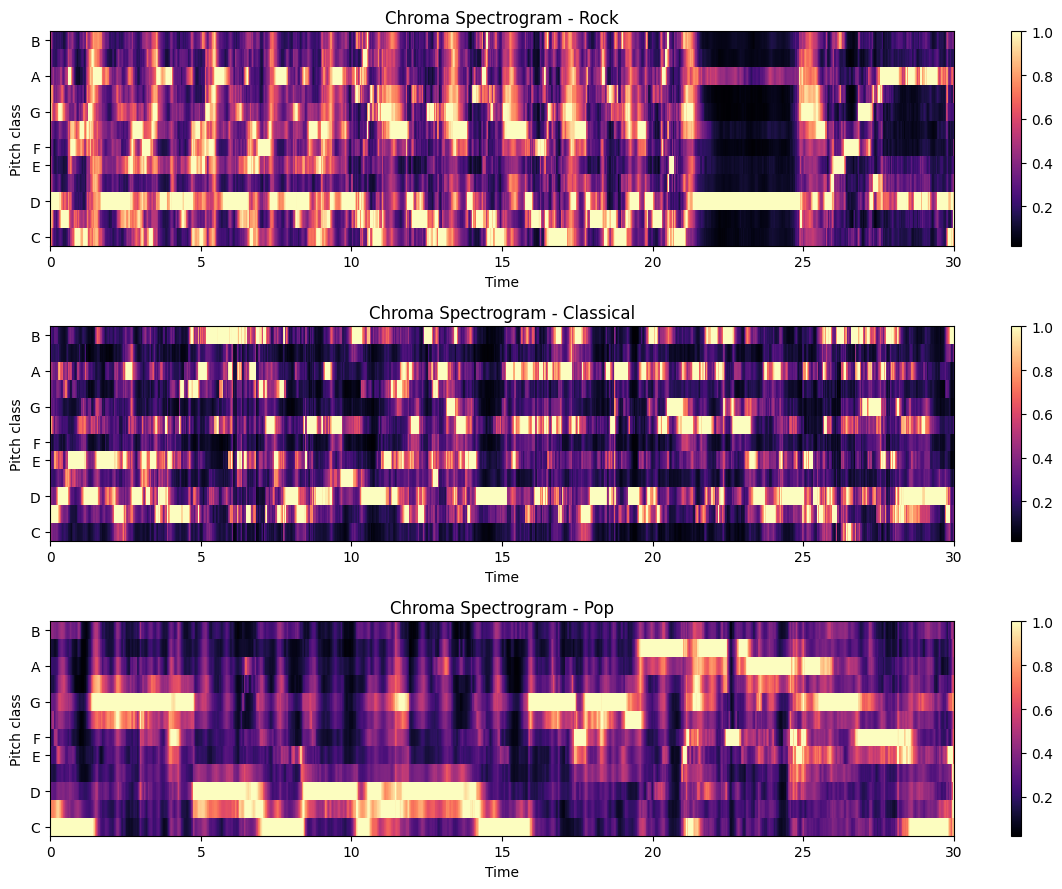

In [90]:
# Chroma Spectogram
# This represents the energy distribution across pitch classes
# Lets compare 3 genres, Rock, Pop and Classical

rock, r_sr = librosa.load("Data/genres_original/rock/rock.00000.wav")
classical, c_sr = librosa.load("Data/genres_original/classical/classical.00000.wav")
pop, p_sr = librosa.load("Data/genres_original/pop/pop.00000.wav")



# Compute chroma spectrograms for each genre
chroma_rock = librosa.feature.chroma_cqt(y=rock, sr=r_sr)
chroma_cls = librosa.feature.chroma_cqt(y=classical, sr=c_sr)
chroma_pop = librosa.feature.chroma_cqt(y=pop, sr=p_sr)


# Plot the chroma spectrograms for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(chroma_rock, sr=r_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Rock')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(chroma_cls, sr=c_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Classical')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(chroma_pop, sr=p_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Pop')
plt.colorbar()
plt.tight_layout()

plt.show()

As can be seen through the chroma spectogram, the Rock and Classical Music seem to have the melodies consisting to a lot of notes at the same time, while the pop music(for general audience) consist very few notes at the same instant.
Even if multiple notes are present at same time in Pop, they are usually harmonies i.e. 3rd or 5th of the root note.

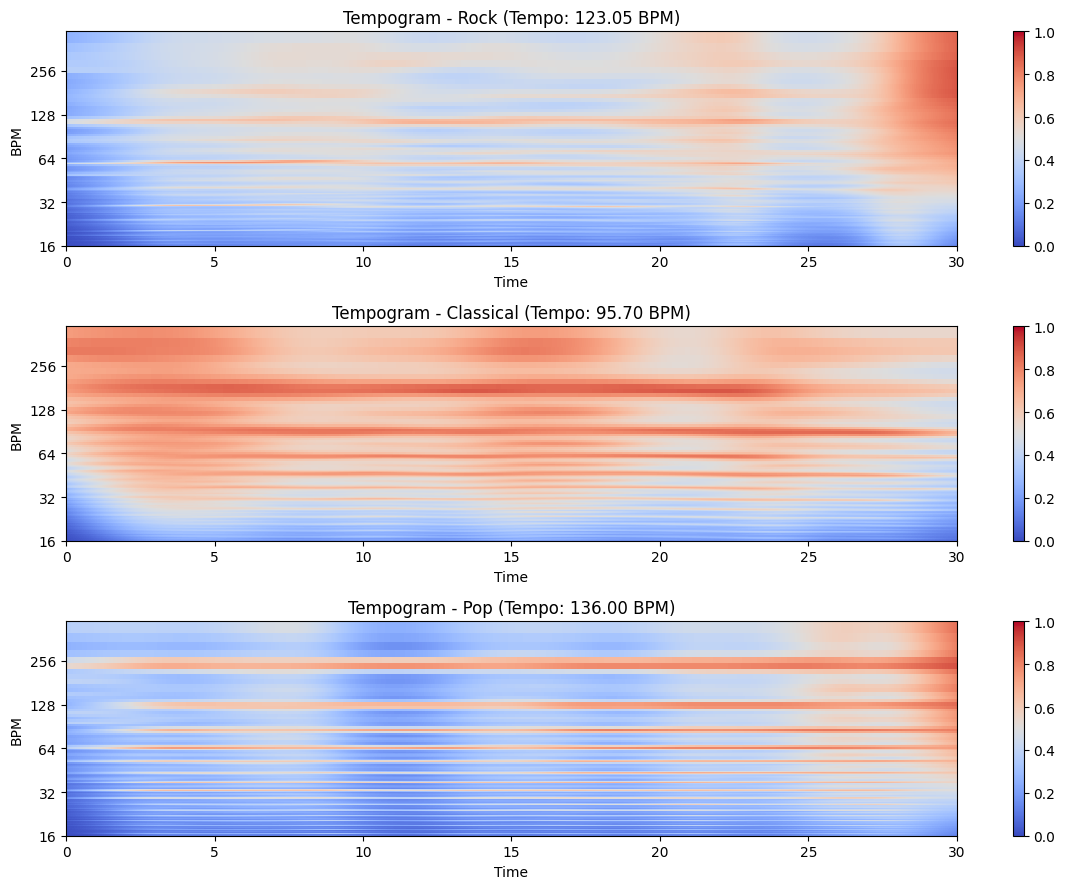

In [91]:
# Compute tempograms for each genre
tempo_rock= librosa.beat.tempo(y=rock, sr=r_sr)
tempogram_rock = librosa.feature.tempogram(y=rock, sr=r_sr, hop_length=512, win_length=384, window=np.hanning)

tempo_cls = librosa.beat.tempo(y=classical, sr=c_sr)
tempogram_cls = librosa.feature.tempogram(y=classical, sr=c_sr, hop_length=512, win_length=384, window=np.hanning)

tempo_pop = librosa.beat.tempo(y=pop, sr=p_sr)
tempogram_pop = librosa.feature.tempogram(y=pop, sr=p_sr, hop_length=512, win_length=384, window=np.hanning)

# Plot the tempograms for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Rock (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Classical (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Pop (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()

plt.show()

Not much can be said able the genres with just looking at the tempograms, 
so let's overlay the tempogram with the CQT spectogram, which provides the pitch over time for the audio file.

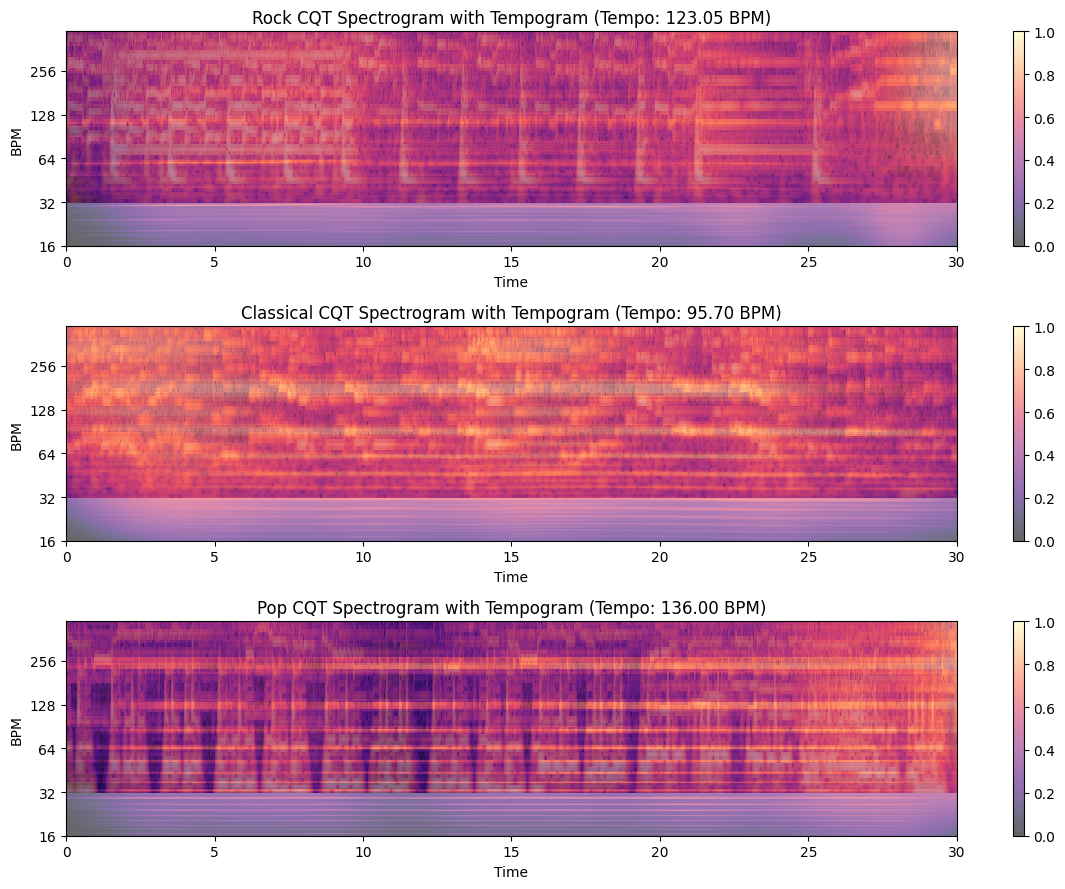

In [92]:
# Compute CQT spectrograms for each genre
cqt_rock = np.abs(librosa.cqt(rock, sr=r_sr, hop_length=512))
cqt_cls = np.abs(librosa.cqt(classical, sr=c_sr, hop_length=512))
cqt_pop = np.abs(librosa.cqt(pop, sr=p_sr, hop_length=512))

# cqt_rock = sklearn.preprocessing.scale(cqt_rock, axis=1)
# cqt_cls = sklearn.preprocessing.scale(cqt_cls, axis=1)
# cqt_pop = sklearn.preprocessing.scale(cqt_pop, axis=1)
# Plot the CQT spectrograms with tempograms overlaid for each genre
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_rock, ref=np.max), sr=r_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Rock CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_cls, ref=np.max), sr=c_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Classical CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(cqt_pop, ref=np.max), sr=p_sr, hop_length=512, x_axis='time', y_axis='cqt_note')
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo', cmap='magma', alpha=0.6)
plt.title('Pop CQT Spectrogram with Tempogram (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()

plt.show()


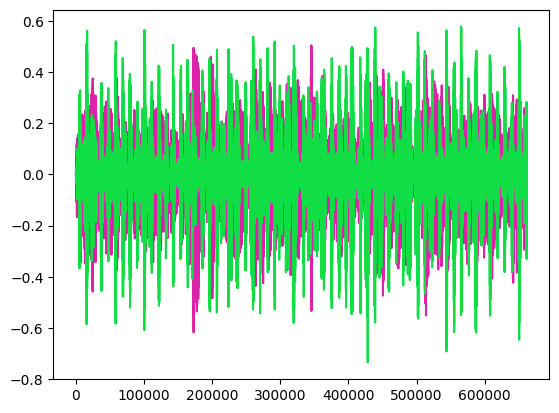

In [93]:
# Harmonics and Percussive for the Audio file

y_harm, y_perc = librosa.effects.hpss(y)
plt.plot(y_harm, color = '#DD22AA')
plt.plot(y_perc, color = '#11DD44')
plt.show()

In [94]:
data = pd.read_csv("Data/features_3_sec.csv")
print(data.shape)

(9990, 60)


In [95]:
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

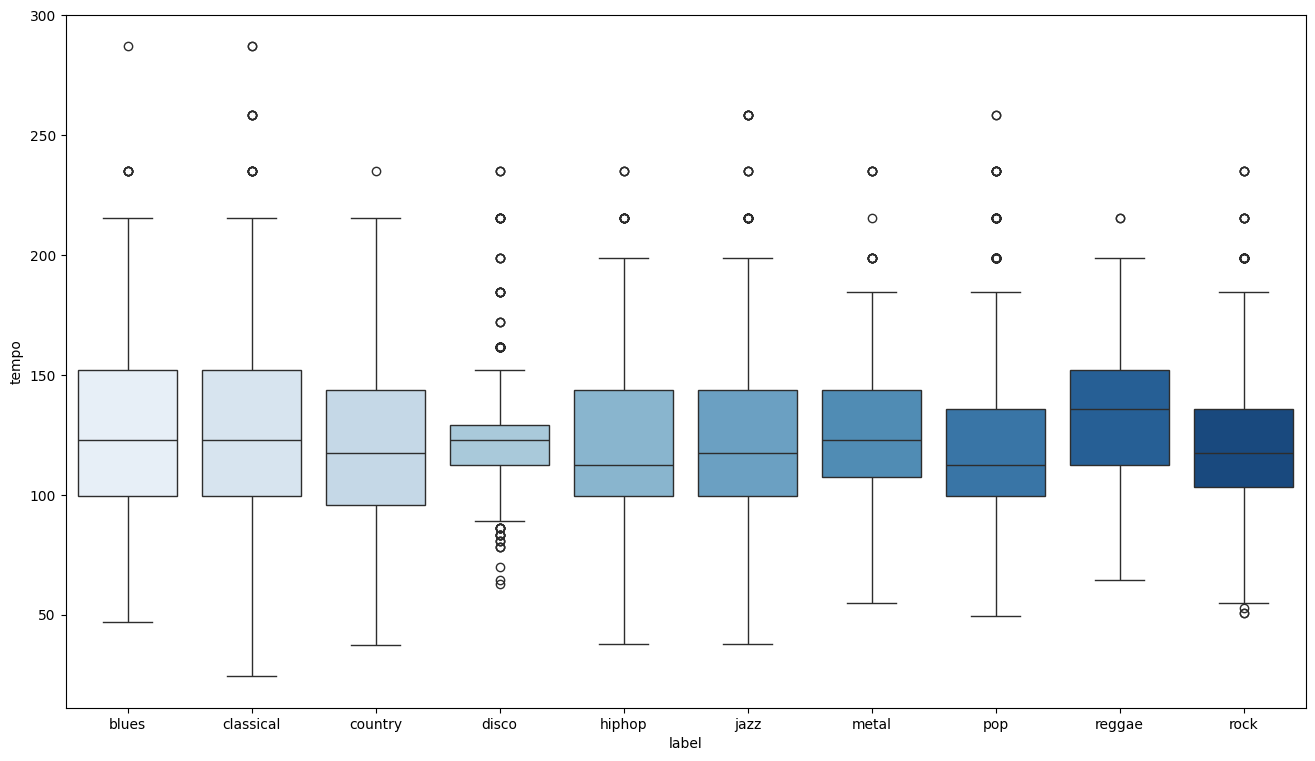

In [97]:
# Box plot of label vs tempo
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'Blues')

plt.show()

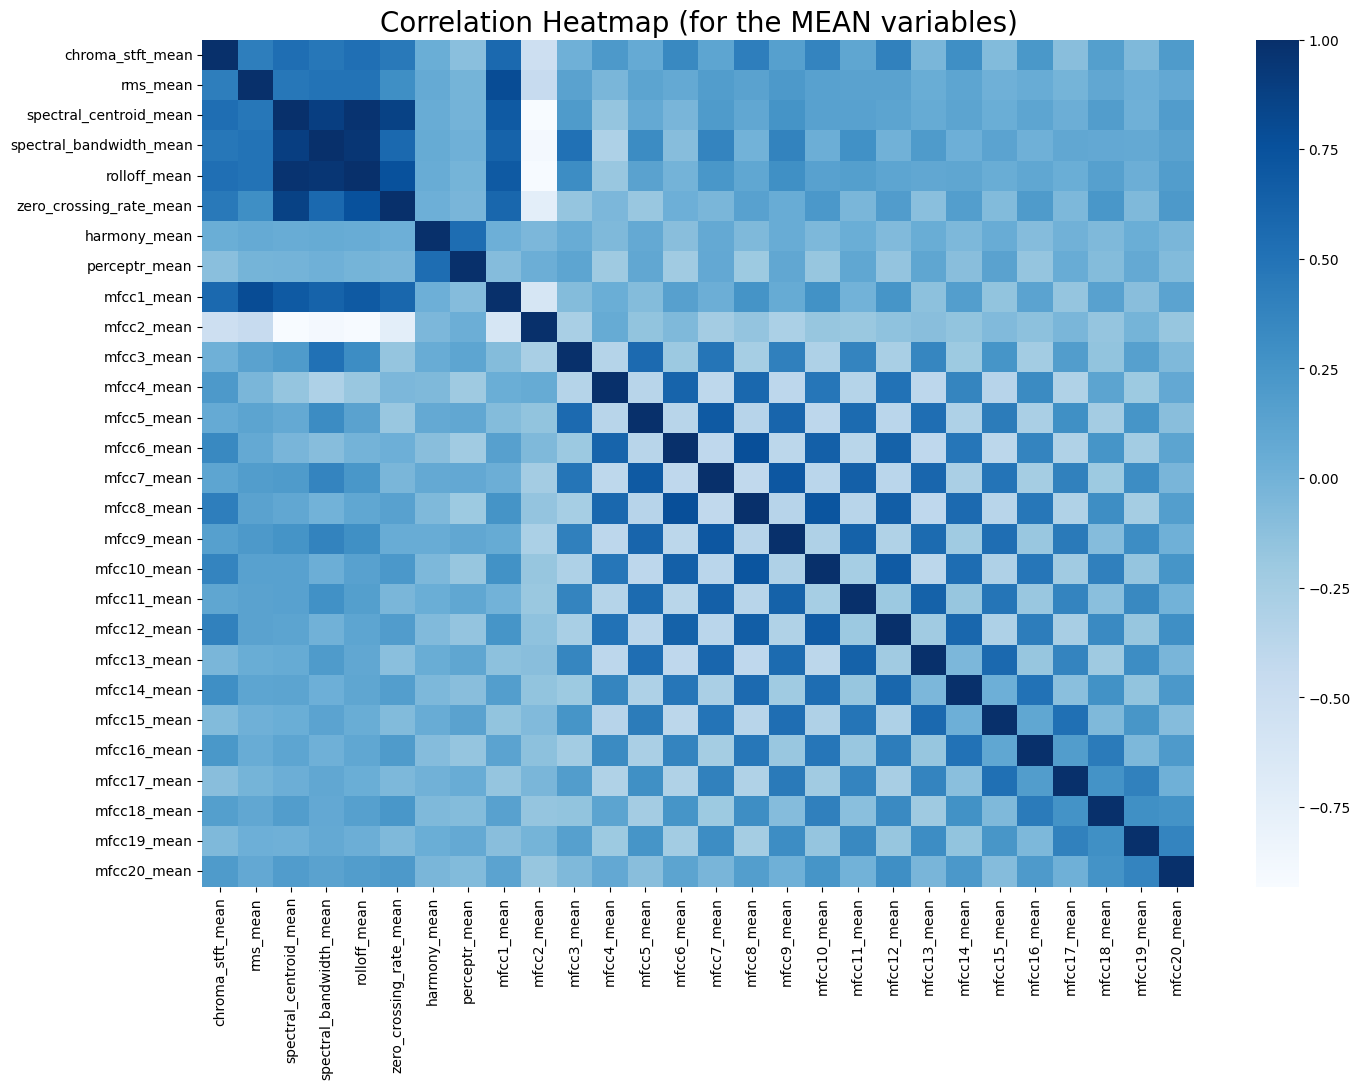

In [98]:
# Heat map for the mean variables
mean_cols = [col for col in data.columns if 'mean' in col]

corr = data[mean_cols].corr()
f, ax = plt.subplots(figsize=(16, 11))

sns.heatmap(corr, cmap = 'Blues')
plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

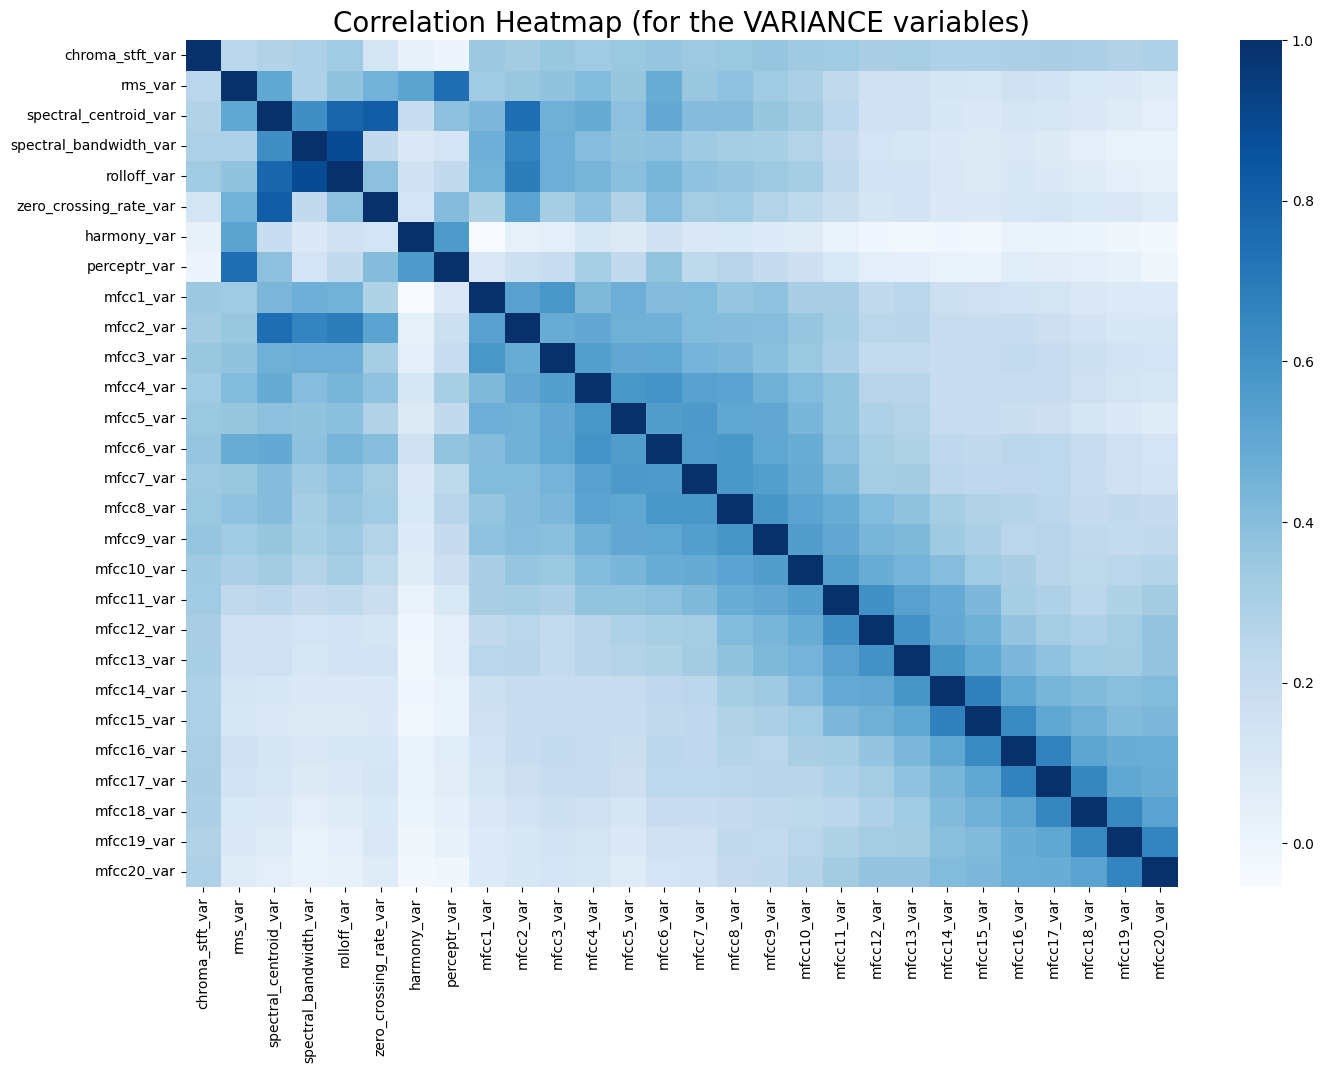

In [99]:
# Heat map for Variance variables
var_cols = [col for col in data.columns if 'var' in col]

corr = data[var_cols].corr()
f, ax = plt.subplots(figsize=(16, 11))

sns.heatmap(corr, cmap = 'Blues')
plt.title('Correlation Heatmap (for the VARIANCE variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

In [100]:
data.drop(['filename','length'], axis = 1, inplace = True)

In [101]:
data.head

<bound method NDFrame.head of       chroma_stft_mean  chroma_stft_var  rms_mean   rms_var   
0             0.335406         0.091048  0.130405  0.003521  \
1             0.343065         0.086147  0.112699  0.001450   
2             0.346815         0.092243  0.132003  0.004620   
3             0.363639         0.086856  0.132565  0.002448   
4             0.335579         0.088129  0.143289  0.001701   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean   
0                1773.065032          167541.630869              1972.744388  \
1                1816.693777           90525.690866  

In [102]:
X = data.iloc[:,:-1]

In [103]:
Y = data.iloc[:,-1]

In [104]:
Y

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object

In [105]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

In [106]:
columns = X.columns

In [107]:
X_scaled = pd.DataFrame(scaled_data, columns = columns)

In [108]:
X_scaled.head

<bound method NDFrame.head of       chroma_stft_mean  chroma_stft_var  rms_mean   rms_var   
0             0.355399         0.716757  0.293133  0.107955  \
1             0.367322         0.670347  0.253040  0.044447   
2             0.373159         0.728067  0.296753  0.141663   
3             0.399349         0.677066  0.298024  0.075042   
4             0.355668         0.689113  0.322308  0.052149   
...                ...              ...       ...       ...   
9985          0.376757         0.617031  0.111106  0.002984   
9986          0.413243         0.637013  0.128944  0.002687   
9987          0.374196         0.697548  0.116503  0.021500   
9988          0.436537         0.657745  0.148266  0.009825   
9989          0.408151         0.676143  0.112249  0.002048   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean   
0                   0.262173               0.034784                 0.459205  \
1                   0.270969               0.018716  

In [109]:
for i in range(1,57):
    pca_dummy = PCA(n_components = i)

    dummy_trans = pca_dummy.fit_transform(X_scaled)

    print("For", i," no. of components Explained Variance Ratio =", pca_dummy.explained_variance_ratio_.cumsum()[i-1])

For 1  no. of components Explained Variance Ratio = 0.2674562115423105
For 2  no. of components Explained Variance Ratio = 0.4498362440131939
For 3  no. of components Explained Variance Ratio = 0.5307729242137377
For 4  no. of components Explained Variance Ratio = 0.5880377921867367
For 5  no. of components Explained Variance Ratio = 0.6380888840550969
For 6  no. of components Explained Variance Ratio = 0.6777283774422078
For 7  no. of components Explained Variance Ratio = 0.7058158360939838
For 8  no. of components Explained Variance Ratio = 0.7316684484827402
For 9  no. of components Explained Variance Ratio = 0.7525316389926104
For 10  no. of components Explained Variance Ratio = 0.7708343347837092
For 11  no. of components Explained Variance Ratio = 0.786068548656123
For 12  no. of components Explained Variance Ratio = 0.8006194314684396
For 13  no. of components Explained Variance Ratio = 0.8135690020534986
For 14  no. of components Explained Variance Ratio = 0.8250949037799632
Fo

In [110]:
# 90% of variance can be explained using 24 components
pca = PCA(n_components = 24)
components = pca.fit_transform(X_scaled)

X_pca = pd.DataFrame(components)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,Y, test_size=0.2, random_state=30)

In [112]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
3464,-0.572951,0.201434,-0.115937,0.239000,0.067302,-0.081839,-0.046220,-0.012512,0.136989,0.256498,...,-0.089668,0.025963,-0.060891,0.072133,0.001390,0.040793,-0.005311,0.031357,0.030260,-0.137737
8204,-0.157563,-0.215466,0.081859,0.048264,0.101965,-0.004879,-0.022933,0.108857,0.027315,0.165615,...,-0.036930,-0.065634,-0.056770,0.021611,0.140168,-0.012605,-0.015596,-0.017351,-0.006954,0.073533
2420,0.122325,0.149607,-0.227326,-0.005400,-0.043761,-0.243893,0.033670,-0.061222,-0.207355,-0.131735,...,0.027219,0.015767,-0.012077,-0.042216,-0.036934,0.030088,0.079231,-0.044033,0.018501,-0.060697
9438,-0.147923,0.390750,-0.274402,-0.206363,0.160325,0.001107,-0.208734,-0.132142,0.334645,0.285174,...,-0.073865,0.101272,-0.048873,0.002342,-0.007523,-0.140899,0.079263,0.054919,-0.018832,-0.035759
5079,-0.329471,0.173976,0.158814,-0.371488,-0.074479,0.039214,0.074462,-0.074968,0.092140,0.048381,...,0.017219,-0.052875,0.003790,0.046733,-0.084692,0.073312,-0.022961,-0.055768,-0.002142,0.153210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,-0.045763,-0.191241,0.071870,-0.043078,-0.227238,0.251087,-0.115615,-0.082389,0.004619,-0.013688,...,-0.029371,0.144054,-0.012059,0.088388,0.087676,-0.060875,-0.019022,-0.080215,0.062548,0.027581
919,-0.407303,0.067559,-0.035862,-0.175826,-0.011658,0.019906,0.116411,0.009978,0.075478,0.114816,...,-0.018294,0.081097,0.040771,0.048446,-0.010150,-0.019659,0.003405,-0.019374,0.025209,-0.012410
500,-0.126057,-0.345201,-0.021588,-0.180417,-0.000471,-0.086997,-0.179242,0.068223,-0.041288,0.060557,...,0.051785,-0.076005,-0.030998,0.073754,0.029893,-0.052467,-0.035820,0.025219,0.034739,-0.062142
4517,0.288444,0.159433,-0.239583,-0.197313,-0.308333,-0.057462,-0.021572,-0.099977,0.090001,-0.061627,...,-0.044183,-0.008128,0.038640,-0.040569,-0.041062,0.026414,0.060126,-0.052287,0.036575,-0.060624


In [113]:
# Importing necessary libraries

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [114]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for KNN
param_found_knn = 1

knn_params = {
    'n_neighbors': range(1, 21),  # Considering a range that isn't too broad
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # Adding different distance metrics
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', verbose=1)

if not param_found_knn: 
    knn_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for KNN:", knn_grid.best_params_)
    print("Best cross-validation score for KNN:", knn_grid.best_score_)

else:
    knn_grid.best_params_ = {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


In [115]:
"""Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Best cross-validation score for KNN: 0.897649031270326"""


# Training KNN with the best parameters
knn_best = KNeighborsClassifier(**knn_grid.best_params_)
knn_best.fit(X_train, y_train)
y_pred_knn_test = knn_best.predict(X_test)
y_pred_knn_train = knn_best.predict(X_train)

# Evaluation
knn_accuracy_test = accuracy_score(y_test, y_pred_knn_test)
knn_accuracy_train = accuracy_score(y_train, y_pred_knn_train)
knn_report = classification_report(y_test, y_pred_knn_test, output_dict=True)
print("Accuracy using KNN =", knn_accuracy_test)

Accuracy using KNN = 0.9124124124124124


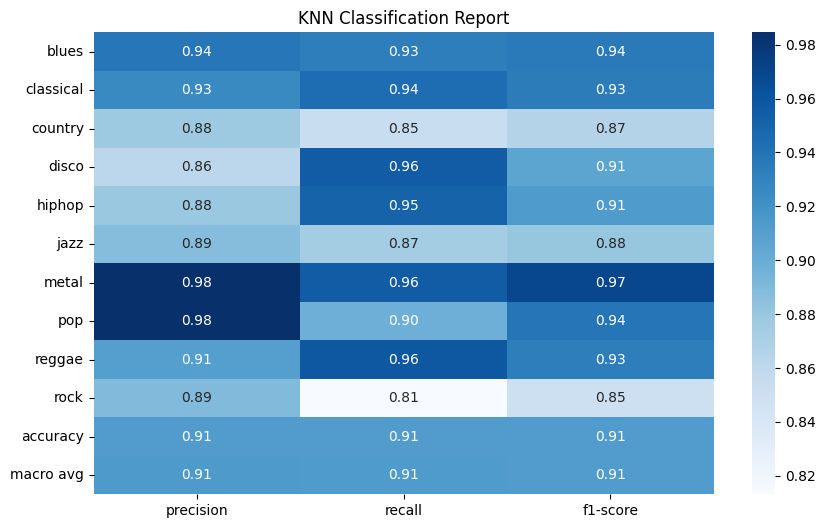

In [116]:
# Transform classification report into DataFrame
knn_report_df = pd.DataFrame(knn_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=knn_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('KNN Classification Report')
plt.show()

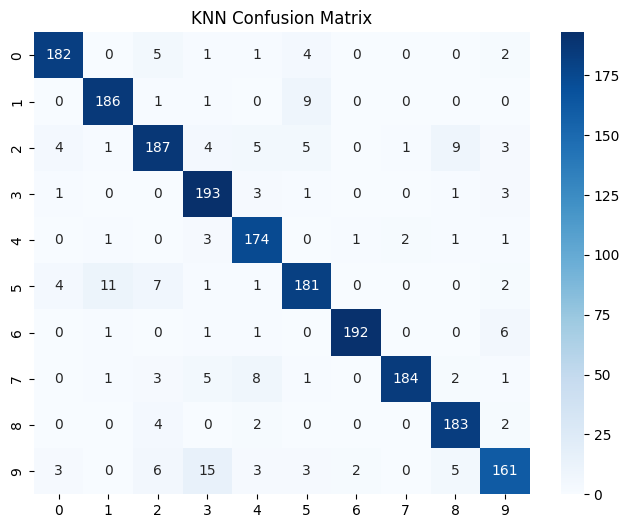

In [117]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()

In [118]:
# Setting up the parameter grid for Decision Trees

param_found_dt = 1
dt_params = {
    'max_depth': range(5, 10),  # Max depth to prevent overfitting
    'min_samples_split': range(2, 10, 2),  # Moderate range for minimum samples split
    'min_samples_leaf': range(1, 5)  # Minimum samples per leaf to ensure generalization
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', verbose=1)

if not param_found_dt:
    dt_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for Decision Tree:", dt_grid.best_params_)
    print("Best cross-validation score for Decision Tree:", dt_grid.best_score_)

else:
    dt_grid.best_params_ = {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [119]:
"""Best parameters for Decision Tree: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best cross-validation score for Decision Tree: 0.5446695016675785"""


# Training Decision Tree with the best parameters
dt_best = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
dt_best.fit(X_train, y_train)
y_pred_dt_test = dt_best.predict(X_test)
y_pred_dt_train = dt_best.predict(X_train)

# Evaluation
dt_accuracy_test = accuracy_score(y_test, y_pred_dt_test)
dt_accuracy_train = accuracy_score(y_train, y_pred_dt_train)
dt_report = classification_report(y_test, y_pred_dt_test, output_dict=True)
print("Accuracy using Decision Tree =", dt_accuracy_test)


Accuracy using Decision Tree = 0.5785785785785785


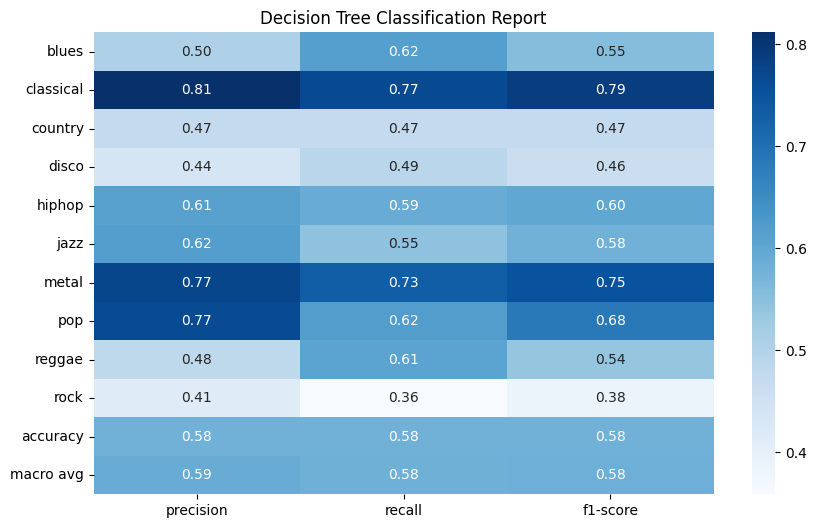

In [120]:
# Transform classification report into DataFrame
dt_report_df = pd.DataFrame(dt_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=dt_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('Decision Tree Classification Report')
plt.show()


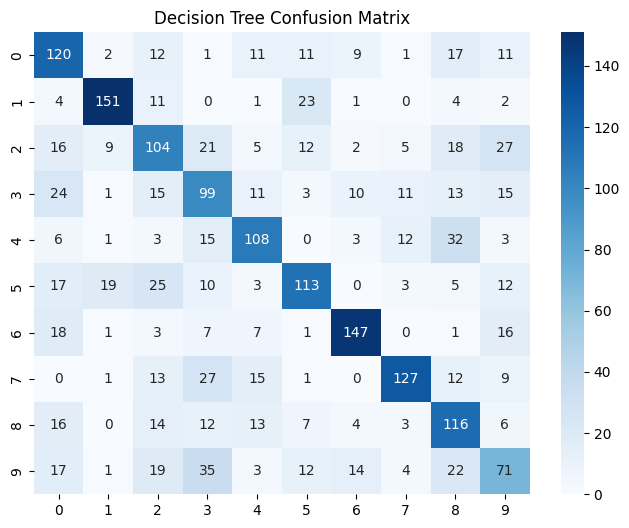

In [121]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_dt_test), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()


In [122]:
# Setting up the parameter grid for SVM

param_found_svm = 1
svm_params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Different types of kernels
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=5, scoring='accuracy', verbose=1)
if not param_found_svm:

    svm_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for SVM:", svm_grid.best_params_)
    print("Best cross-validation score for SVM:", svm_grid.best_score_)

else:
    svm_grid.best_params_ = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [123]:
"""Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score for SVM: 0.8843858919960145"""

# Training SVM with the best parameters
svm_best = SVC(**svm_grid.best_params_, random_state=42)
svm_best.fit(X_train, y_train)
y_pred_svm_test = svm_best.predict(X_test)
y_pred_svm_train = svm_best.predict(X_train)

# Evaluation
svm_accuracy_test = accuracy_score(y_test, y_pred_svm_test)
svm_accuracy_train = accuracy_score(y_train, y_pred_svm_train)
svm_report = classification_report(y_test, y_pred_svm_test, output_dict=True)

print("Accuracy using SVM =", svm_accuracy_test)

Accuracy using SVM = 0.8978978978978979


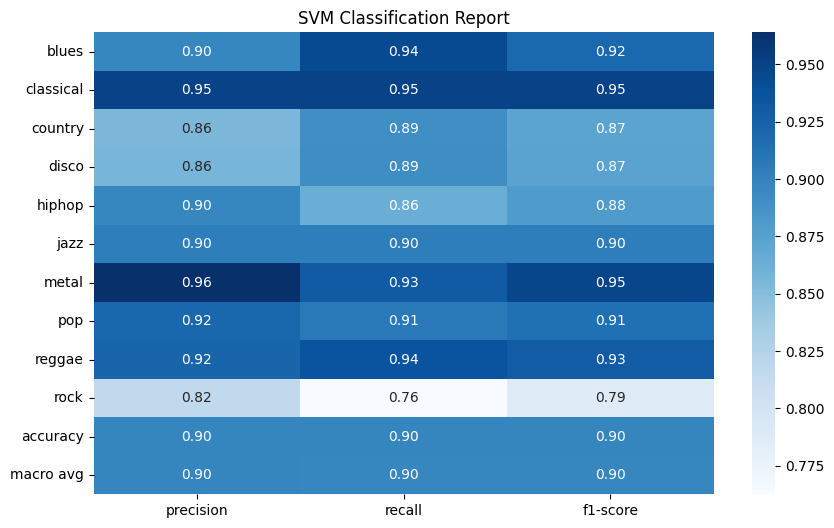

In [124]:
# Transform classification report into DataFrame
svm_report_df = pd.DataFrame(svm_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=svm_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('SVM Classification Report')
plt.show()


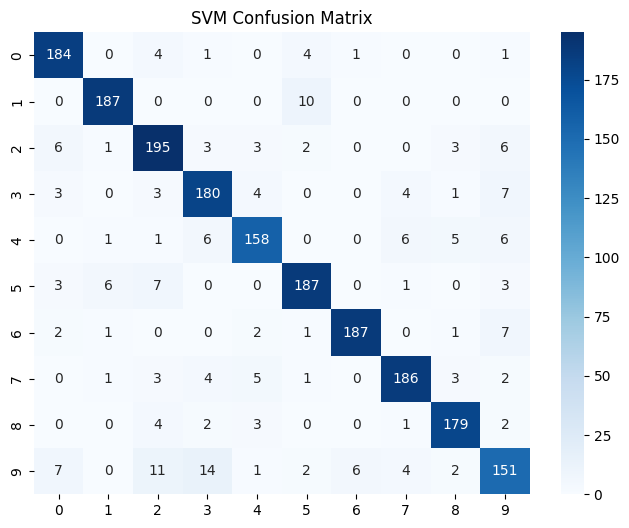

In [125]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

In [126]:
from sklearn.ensemble import AdaBoostClassifier

param_found_ada = 1
adaboost_params = {
    'n_estimators': [50, 100, 150, 200], # Number of models to iteratively train
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1] # Weight applied to each classifier at each boosting iteration
}
adaboost_grid = GridSearchCV(AdaBoostClassifier(random_state=42), adaboost_params, cv=5, scoring='accuracy', verbose=1)
if not param_found_ada:
# Setting up the parameter grid for Adaboost
    
    adaboost_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for Adaboost:", adaboost_grid.best_params_)
    print("Best cross-validation score for Adaboost:", adaboost_grid.best_score_)
else:
    adaboost_grid.best_params_ = {'learning_rate': 0.5, 'n_estimators': 50}


In [127]:
"""Best parameters for Adaboost: {'learning_rate': 0.5, 'n_estimators': 50}
Best cross-validation score for Adaboost: 0.3900166014272061"""

# Training Adaboost with the best parameters
adaboost_best = AdaBoostClassifier(**adaboost_grid.best_params_, random_state=42)
adaboost_best.fit(X_train, y_train)
y_pred_adaboost_test = adaboost_best.predict(X_test)
y_pred_adaboost_train = adaboost_best.predict(X_train)

# Evaluation
adaboost_accuracy_test = accuracy_score(y_test, y_pred_adaboost_test)
adaboost_accuracy_train = accuracy_score(y_train, y_pred_adaboost_train)
adaboost_report = classification_report(y_test, y_pred_adaboost_test, output_dict=True)

print("Accuracy using Adaboost =", adaboost_accuracy_test)

Accuracy using Adaboost = 0.36936936936936937


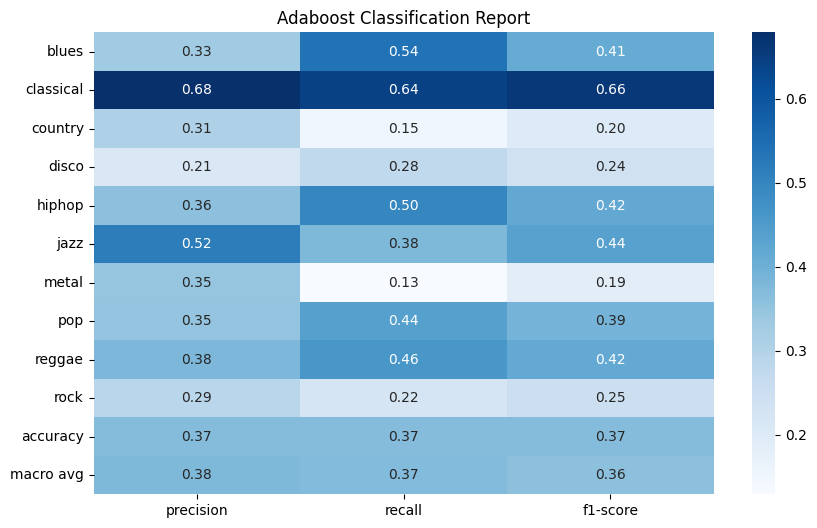

In [128]:
# Transform classification report into DataFrame
adaboost_report_df = pd.DataFrame(adaboost_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=adaboost_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('Adaboost Classification Report')
plt.show()


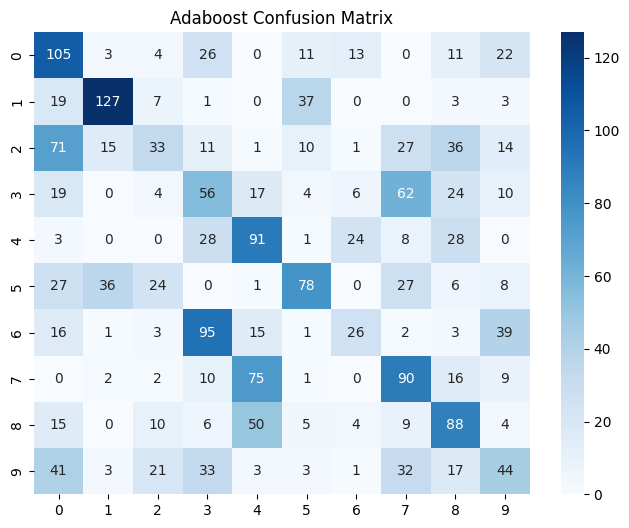

In [129]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_adaboost_test), annot=True, fmt='d', cmap='Blues')
plt.title('Adaboost Confusion Matrix')
plt.show()

In [130]:
# Setting up the parameter grid for Logistic Regression
param_found_lr = 1

lr_params = {
    'C': [0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5)

if not param_found_ada:
    lr_grid.fit(X_train, y_train)

    # Best parameters and best score
    print("Best parameters for Logistic Regression:", lr_grid.best_params_)
    print("Best cross-validation score for Logistic Regression:", lr_grid.best_score_)

else:
    lr_grid.best_params_= {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}


In [131]:
"""Best parameters for Logistic Regression: {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score for Logistic Regression: 0.6521534500990528"""

# Training Logistic Regression with the best parameters
lr_best = LogisticRegression(**lr_grid.best_params_, random_state=42)
lr_best.fit(X_train, y_train)
y_pred_lr_test = lr_best.predict(X_test)
y_pred_lr_train = lr_best.predict(X_train)

# Evaluation
lr_accuracy_test = accuracy_score(y_test, y_pred_lr_test)
lr_accuracy_train = accuracy_score(y_train, y_pred_lr_train)
lr_report = classification_report(y_test, y_pred_lr_test, output_dict=True)

print("Accuracy using Logistic Regression =", lr_accuracy_test)

Accuracy using Logistic Regression = 0.6646646646646647


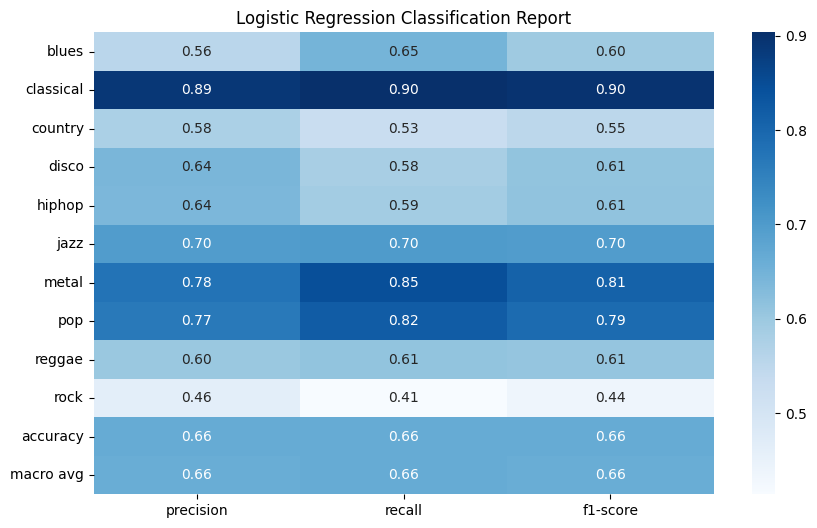

In [132]:
# Transform classification report into DataFrame
lr_report_df = pd.DataFrame(lr_report).transpose()

# Plotting the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(data=lr_report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
plt.title('Logistic Regression Classification Report')
plt.show()


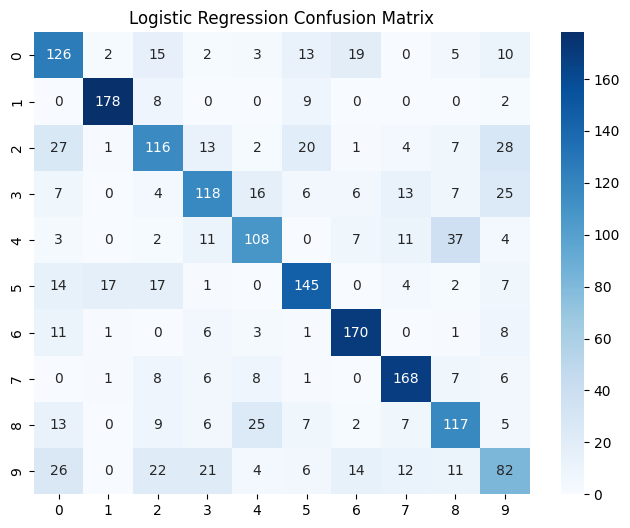

In [133]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

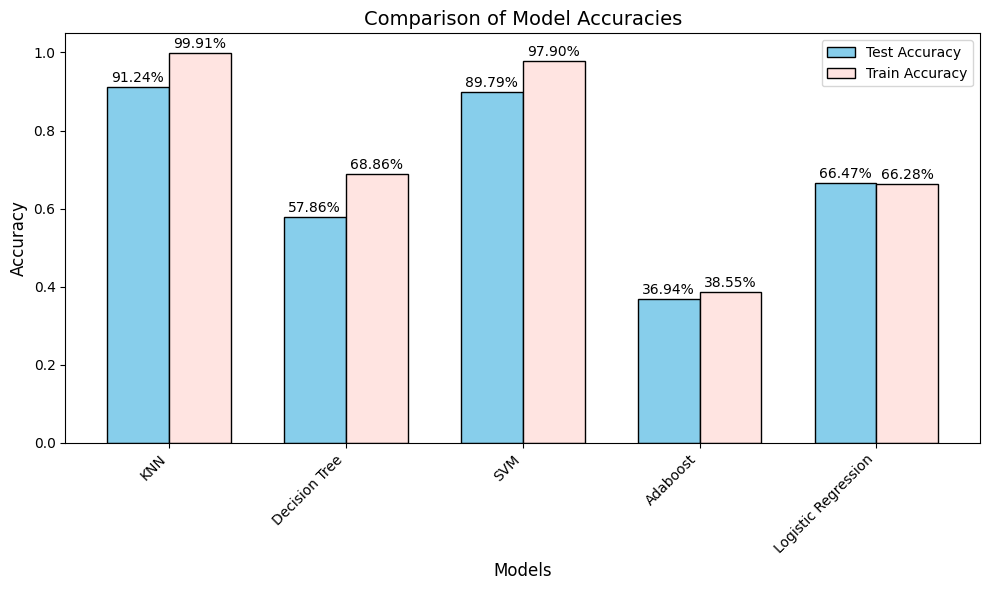

In [135]:
models = ['KNN', 'Decision Tree', 'SVM', 'Adaboost', 'Logistic Regression']

index = np.arange(len(models))
bar_width = 0.35

# Corresponding accuracies
test_accuracies = [knn_accuracy_test, dt_accuracy_test, svm_accuracy_test, adaboost_accuracy_test, lr_accuracy_test]
train_accuracies = [knn_accuracy_train, dt_accuracy_train, svm_accuracy_train, adaboost_accuracy_train, lr_accuracy_train]

# Creating the bar chart
plt.figure(figsize=(10, 6))

plt.bar(index, test_accuracies, bar_width, label='Test Accuracy', color="skyblue", edgecolor='black')
plt.bar(index + bar_width, train_accuracies, bar_width, label='Train Accuracy', color="mistyrose", edgecolor='black')

# Adding text labels
for i in range(len(index)):
    plt.text(i, test_accuracies[i] + 0.005, f'{test_accuracies[i]*100:.2f}%', ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width, train_accuracies[i] + 0.005, f'{train_accuracies[i]*100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()